In [524]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from feature_engine.encoding import WoEEncoder, RareLabelEncoder
from sklearn.feature_selection import f_regression
from sklearn.naive_bayes import CategoricalNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

# 1. General data preparation

In [525]:
#import data
retail_train = pd.read_csv('/Users/yifeichen/Downloads/train.csv')
retail_test = pd.read_csv('/Users/yifeichen/Downloads/test.csv')

# Check missing values, create new label, drop features

In [526]:
#Explore data
retail_train.head()
retail_test.head()

,label,id,visitTime,purchaseTime,hour,C1,C2,C3,C4,C5,C6,C7,C8,N1,C9,N2,N3,N4,N5,N6,N7,N8,N9,N10,C10,C11,C12
0,-1,25540,19420446,-1,16,2569487005,2018710401,1429850909,2308170622,2967512603,1955107518,2303407174,3588031319,0,1097313503,0,0,0,0,0,0,0,0,0,1887882016,3617851689,4220791646
1,-1,29938,19431062,-1,19,1981742921,1235983246,4203734567,652481754,2116767313,2008267349,2303407174,2374954832,0,114495992,0,0,0,0,0,0,0,0,0,3375463994,2379633508,1284343215
2,-1,9585,19392956,-1,8,2486871669,1235983246,2776175989,652481754,2116767313,571765677,2303407174,2374954832,0,2226682598,0,0,0,0,0,0,0,0,0,3441876061,2196958187,1550397227
3,-1,23597,19416124,-1,15,3427628467,1235983246,4172481347,652481754,2116767313,571765677,2303407174,2374954832,0,2226682598,0,0,0,0,0,0,0,0,0,2835356425,3831440054,1213938795
4,-1,27695,19425109,-1,17,2214885086,2541203883,3948279888,652481754,2967512603,4015714422,2303407174,2206061889,0,3911032568,0,0,0,0,0,0,0,0,0,1453469701,3831440054,830706566


In [527]:
#check if the IDs are unique: yes they are, so there is no need to group data
len(retail_train)
retail_train['id'].value_counts()

595965    1
564857    1
548481    1
83586     1
95876     1
         ..
554107    1
214141    1
351358    1
174178    1
327680    1
Name: id, Length: 31428, dtype: int64

In [528]:
#check missing values: no missing values for both training and testing sets
retail_train.isnull().any()

label           False
id              False
visitTime       False
purchaseTime    False
hour            False
C1              False
C2              False
C3              False
C4              False
C5              False
C6              False
C7              False
C8              False
N1              False
C9              False
N2              False
N3              False
N4              False
N5              False
N6              False
N7              False
N8              False
N9              False
N10             False
C10             False
C11             False
C12             False
dtype: bool

In [529]:
retail_test.isnull().any()

label           False
id              False
visitTime       False
purchaseTime    False
hour            False
C1              False
C2              False
C3              False
C4              False
C5              False
C6              False
C7              False
C8              False
N1              False
C9              False
N2              False
N3              False
N4              False
N5              False
N6              False
N7              False
N8              False
N9              False
N10             False
C10             False
C11             False
C12             False
dtype: bool

In [530]:
#check duplicates: no duplicates in training and testing data
retail_train.duplicated().any()
retail_test.duplicated().any()

False

In [531]:
#check unique labels in training dataset：
#1) the negative samples were labelled as -1 
# 2） the training dataset is extremely imbalanced
retail_train['label'].value_counts() 

-1    31371
 1       57
Name: label, dtype: int64

In [532]:
# 1) For negative samples, replace label -1 with 0 in both datasets
retail_train['newlabel'] = retail_train.label.map(lambda x: 0 if x == -1 else 1)
retail_test['newlabel'] = retail_test.label.map(lambda x: 0 if x == -1 else 1)

In [533]:
retail_train['newlabel'].value_counts() 

0    31371
1       57
Name: newlabel, dtype: int64

In [534]:
#drop the original label
train_new = retail_train.drop(['label'], axis = 1)
test_new = retail_test.drop(['label'], axis = 1)

In [535]:
#final check on training and testing datasets
train_new.head()

,id,visitTime,purchaseTime,hour,C1,C2,C3,C4,C5,C6,C7,C8,N1,C9,N2,N3,N4,N5,N6,N7,N8,N9,N10,C10,C11,C12,newlabel
0,61518,19297675,-1,6,928106152,2541203883,3606287998,306394936,2967512603,2712499304,2303407174,434828410,0,385980380,0,0,0,0,0,0,0,0,0,1083418268,3831440054,830706566,0
1,356604,19320277,-1,12,3382400190,2018710401,1302581498,2308170622,2967512603,179712055,1342367140,157533148,1,3272771221,0,4,2,0,0,0,6,0,0,2993954402,2379633508,1284343215,0
2,603441,19346318,-1,20,2569487005,2018710401,4121075497,2210625817,2967512603,2900447837,2303407174,2206061889,0,138171148,0,0,0,0,0,0,0,0,0,1601090997,3617851689,4220791646,0
3,192754,19308171,-1,9,2569487005,2018710401,3531445293,652481754,2967512603,487561405,2303407174,157533148,0,986337892,0,0,0,0,0,0,0,0,0,4114483006,3617851689,4220791646,0
4,210892,19309442,-1,9,1659166197,2018710401,1047694444,2210625817,2967512603,2712499304,2303407174,1804593680,0,385980380,0,0,0,0,0,0,0,0,0,1971402551,2196958187,830706566,0


In [536]:
test_new.head()

,id,visitTime,purchaseTime,hour,C1,C2,C3,C4,C5,C6,C7,C8,N1,C9,N2,N3,N4,N5,N6,N7,N8,N9,N10,C10,C11,C12,newlabel
0,25540,19420446,-1,16,2569487005,2018710401,1429850909,2308170622,2967512603,1955107518,2303407174,3588031319,0,1097313503,0,0,0,0,0,0,0,0,0,1887882016,3617851689,4220791646,0
1,29938,19431062,-1,19,1981742921,1235983246,4203734567,652481754,2116767313,2008267349,2303407174,2374954832,0,114495992,0,0,0,0,0,0,0,0,0,3375463994,2379633508,1284343215,0
2,9585,19392956,-1,8,2486871669,1235983246,2776175989,652481754,2116767313,571765677,2303407174,2374954832,0,2226682598,0,0,0,0,0,0,0,0,0,3441876061,2196958187,1550397227,0
3,23597,19416124,-1,15,3427628467,1235983246,4172481347,652481754,2116767313,571765677,2303407174,2374954832,0,2226682598,0,0,0,0,0,0,0,0,0,2835356425,3831440054,1213938795,0
4,27695,19425109,-1,17,2214885086,2541203883,3948279888,652481754,2967512603,4015714422,2303407174,2206061889,0,3911032568,0,0,0,0,0,0,0,0,0,1453469701,3831440054,830706566,0


In [537]:
#drop visitTime and purchaseTime 
train_new = train_new.drop(columns=['visitTime','purchaseTime'], axis = 1)
test_new = test_new.drop(columns=['visitTime','purchaseTime'], axis = 1)

# 2. Training data preprocessing 

# SMOTE for highly imbalanced label

In [539]:
# 2) for imbalanced data, chose oversampling for label 1 using SMOTE
sm = SMOTE(random_state = 42)
X_sm, y_sm = sm.fit_resample(train_new, train_new.newlabel)

In [540]:
print(f'''Shape of X before SMOTE: {train_new.shape}
Shape of X after SMOTE: {X_sm.shape}''')

print('\nBalance of positive and negative classes (%):')
y_sm.value_counts(normalize = True) * 100

Shape of X before SMOTE: (31428, 25)
Shape of X after SMOTE: (62742, 25)

Balance of positive and negative classes (%):


1    50.0
0    50.0
Name: newlabel, dtype: float64

In [541]:
#drop id
X_sm = X_sm.drop(['id'], axis = 1)

# Feature handling: numerical

In [108]:
#isolate the numerical features (column names denoted with N) and apply scaling 

In [543]:
X_sm_num = X_sm[['hour','N1','N2','N3','N4','N5', 'N6','N7', 'N8', 'N9', 'N10']]

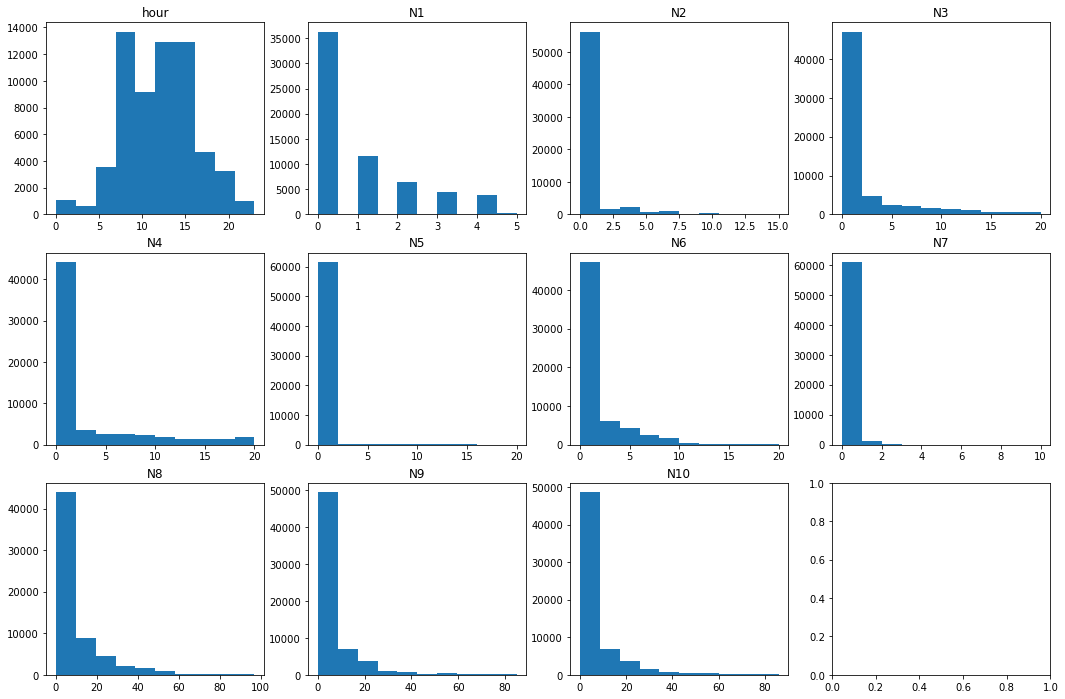

In [544]:
# inspect the distribution of the numerical variables before scaling
fig, subplot_arr = plt.subplots(3,4,figsize=(18,12))
plt.subplot(3, 4, 1)
plt.hist(X_sm_num.loc[:,"hour"])
plt.title("hour")
for i in range(0,10):
  plt.subplot(3, 4, i+2)
  col="N"+str(i+1)
  plt.hist(X_sm_num.loc[:,col])
  plt.title(col)

In [545]:
#apply scaling to numerical features based on distribution:
#apply standardscaler to hour
Scaler = StandardScaler()
X_sm_num.iloc[:,0:1] = Scaler.fit_transform(X_sm_num.iloc[:,0:1])

In [546]:
#apply min-max scaler to the rest 
Scaler1 = MinMaxScaler()
X_sm_num.iloc[:,1:11] = Scaler1.fit_transform(X_sm_num.iloc[:,1:11])

In [547]:
X_sm_num

,hour,N1,N2,N3,N4,N5,N6,N7,N8,N9,N10
0,-1.419245,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.000000,0.000000,0.000000
1,0.023302,0.2,0.0,0.20,0.10,0.0,0.0,0.0,0.061856,0.000000,0.000000
2,1.946698,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.000000,0.000000,0.000000
3,-0.697971,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.000000,0.000000,0.000000
4,-0.697971,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
62737,0.023302,0.6,0.2,0.10,0.75,0.0,0.4,0.0,0.453608,0.352941,0.348837
62738,0.263727,0.2,0.0,0.05,0.35,0.0,0.1,0.0,0.103093,0.082353,0.081395
62739,0.023302,0.0,0.0,0.50,0.00,0.0,0.0,0.0,0.103093,0.000000,0.000000
62740,1.225425,0.4,0.0,0.05,0.60,0.0,0.1,0.0,0.453608,0.517647,0.511628


# Feature handling: categorical

In [548]:
#isolate the categorical features(column names denoted with C)
X_smc = X_sm[['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12']]

In [549]:
#the hased categorical features (column names denoted with C) as well as the class label
#are recognised as integer by the machine, convert to string then apply label encoding 

#1. label encoding: 
#class label
X_sm['newlabel'] = pd.factorize(X_sm['newlabel'].astype(str), sort = False)[0]

In [550]:
X_sm_c = X_smc.astype(str)
X_sm_c1 = X_sm_c.apply(lambda x: pd.factorize(x, sort = False)[0])
X_sm_c1

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12
0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,0,1,1,1,1,1,1,1
2,2,1,2,2,0,2,0,2,2,2,2,2
3,2,1,3,3,0,3,0,1,3,3,2,2
4,3,1,4,2,0,0,0,3,0,4,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...
62737,52975,2,43,3,0,13,20307,8,4,57877,0,19882
62738,52976,2,43,3,0,20646,1,8,15673,57878,12814,19883
62739,52977,16810,27822,3,1,15,20308,4,14,57879,12815,19884
62740,52978,16811,27823,11539,4694,20647,20309,17930,15674,57880,4,3


In [551]:
#2. rare label + weight of evidence (WOE) encoding:
#as the categorical features are hashed, we do not know if they are ordinal data 
#so to avoid ranking these features, we apply rare label + weight of evidence encoding for the categorical features
#this is for the Logistic Regression model, as ordinality isn't a problem for tree-based models

In [553]:
# rare label encoding: 
# we set the threshold to 0.1 
# categories with proportion lower than 0.1 may not have any class label 1 due to the label imbalance
# and this will impede the application of WOE encoding (log 0 is undefined)

encoder = RareLabelEncoder(tol=0.1, n_categories=2, variables=['C1','C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12'],
                           replace_with='Rare')
train_enc = encoder.fit_transform(X_sm_c)

In [554]:
#WOE encoding:
woe_encoder = WoEEncoder(variables=['C1','C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12'])
train_enc1 = woe_encoder.fit_transform(train_enc, X_sm['newlabel'])

In [555]:
train_enc1

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12
0,0.282515,-0.126794,-0.152238,0.245015,-0.045911,0.0,-1.906291,0.786396,-0.219252,0.0,0.416966,0.954288
1,0.282515,-1.351094,-0.152238,-1.141867,-0.045911,0.0,0.408957,-1.636140,-0.219252,0.0,-8.827761,-8.991687
2,-2.199482,-1.351094,-0.152238,2.007391,-0.045911,0.0,-1.906291,-0.525018,-0.219252,0.0,-2.208580,-2.208580
3,-2.199482,-1.351094,-0.152238,-0.381938,-0.045911,0.0,-1.906291,-1.636140,-0.219252,0.0,-2.208580,-2.208580
4,0.282515,-1.351094,-0.152238,2.007391,-0.045911,0.0,-1.906291,0.786396,-0.219252,0.0,0.858263,0.954288
...,...,...,...,...,...,...,...,...,...,...,...,...
62737,0.282515,-0.197315,1.541428,-0.381938,-0.045911,0.0,1.918719,0.786396,0.733646,0.0,0.416966,0.954288
62738,0.282515,-0.197315,1.541428,-0.381938,-0.045911,0.0,0.408957,0.786396,-0.219252,0.0,0.858263,0.954288
62739,0.282515,1.252967,-0.152238,-0.381938,-0.572628,0.0,1.918719,-0.572628,-0.219252,0.0,0.858263,0.954288
62740,0.282515,1.252967,-0.152238,2.007391,5.509388,0.0,1.918719,0.786396,-0.219252,0.0,0.858263,0.278807


# 3. Model Building 

# Logistic Regression

In [556]:
#reassemble training dataset
#for categorical features, use the datasets after applying rare label + WOE encoding

In [557]:
#training dataset
train = X_sm_num.join(train_enc1).join(X_sm['newlabel'])
train

,hour,N1,N2,N3,N4,N5,N6,N7,N8,N9,N10,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,newlabel
0,-1.419245,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.282515,-0.126794,-0.152238,0.245015,-0.045911,0.0,-1.906291,0.786396,-0.219252,0.0,0.416966,0.954288,0
1,0.023302,0.2,0.0,0.20,0.10,0.0,0.0,0.0,0.061856,0.000000,0.000000,0.282515,-1.351094,-0.152238,-1.141867,-0.045911,0.0,0.408957,-1.636140,-0.219252,0.0,-8.827761,-8.991687,0
2,1.946698,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.000000,0.000000,0.000000,-2.199482,-1.351094,-0.152238,2.007391,-0.045911,0.0,-1.906291,-0.525018,-0.219252,0.0,-2.208580,-2.208580,0
3,-0.697971,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.000000,0.000000,0.000000,-2.199482,-1.351094,-0.152238,-0.381938,-0.045911,0.0,-1.906291,-1.636140,-0.219252,0.0,-2.208580,-2.208580,0
4,-0.697971,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.282515,-1.351094,-0.152238,2.007391,-0.045911,0.0,-1.906291,0.786396,-0.219252,0.0,0.858263,0.954288,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62737,0.023302,0.6,0.2,0.10,0.75,0.0,0.4,0.0,0.453608,0.352941,0.348837,0.282515,-0.197315,1.541428,-0.381938,-0.045911,0.0,1.918719,0.786396,0.733646,0.0,0.416966,0.954288,1
62738,0.263727,0.2,0.0,0.05,0.35,0.0,0.1,0.0,0.103093,0.082353,0.081395,0.282515,-0.197315,1.541428,-0.381938,-0.045911,0.0,0.408957,0.786396,-0.219252,0.0,0.858263,0.954288,1
62739,0.023302,0.0,0.0,0.50,0.00,0.0,0.0,0.0,0.103093,0.000000,0.000000,0.282515,1.252967,-0.152238,-0.381938,-0.572628,0.0,1.918719,-0.572628,-0.219252,0.0,0.858263,0.954288,1
62740,1.225425,0.4,0.0,0.05,0.60,0.0,0.1,0.0,0.453608,0.517647,0.511628,0.282515,1.252967,-0.152238,2.007391,5.509388,0.0,1.918719,0.786396,-0.219252,0.0,0.858263,0.278807,1


In [558]:
# split the training dataset into train and test set 
X = train
y = train['newlabel'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [559]:
#Model 1

In [560]:
prediction = dict() 
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [566]:
#get coefficients and P value
model_coeffs = model.coef_
print("Coefficients:")
print(model_coeffs)
f_val, p_val = f_regression(X_train, y_train)
print("\n")
print("P value:") # all features but two are statistically significant
p_val

Coefficients:
[[-1.93124922e-01 -1.05547001e+00 -6.52663721e-01  9.93280274e-01
   6.34162297e-01  9.32423055e-02  4.10100841e-01 -9.75457494e-03
   5.77704071e-01  5.76869079e-01  5.91698032e-01 -2.85544351e-01
   4.02826223e-01  5.72490482e-01  4.05126211e-01  2.09025656e-01
   0.00000000e+00  4.53734526e-01  5.63464235e-01  5.09256101e-01
   0.00000000e+00  8.60844252e-02  4.06397424e-01  1.28653807e+01]]


P value:


array([7.66811548e-008, 0.00000000e+000, 6.06272801e-030, 0.00000000e+000,
       0.00000000e+000, 1.71866077e-160, 0.00000000e+000, 4.45717419e-227,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
                   nan, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
                   nan, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000])

In [567]:
X_train.columns

Index(['hour', 'N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'N7', 'N8', 'N9', 'N10',
       'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'newlabel'],
      dtype='object')

In [568]:
#build a new train, test set with features that have coefficients higher than 0.5 
X_train_new = X_train[['N1','N2','N3','N4','N8','N9','N10','C3','C8','C9', 'newlabel']]
X_test_new = X_test[['N1','N2','N3','N4','N8','N9', 'N10','C3','C8','C9', 'newlabel']]

In [569]:
#Model 2

In [570]:
prediction = dict() 
LR = LogisticRegression()
LR.fit(X_train_new, y_train)

LogisticRegression()

In [571]:
coeffs = LR.coef_
coeffs

array([[ 0.31759121, -0.14702411,  1.39719971,  1.11855884,  0.93048764,
         0.82972924,  0.85915519,  0.42657068,  0.46898697,  0.39580553,
        14.05648134]])

In [572]:
#build the final train, test set with features that have coefficients higher than 0.5 
X_train_new = X_train[['N3','N4','N8','N9','N10','newlabel']]
X_test_new = X_test[['N3','N4','N8','N9', 'N10','newlabel']]

In [573]:
#Model 3: Final

In [574]:
prediction = dict() 
LR_final = LogisticRegression()
LR_final.fit(X_train_new, y_train)

LogisticRegression()

In [575]:
prediction['Logistic Regression'] = LR_final.predict(X_test_new)

In [576]:
#accuracy, precision, recall, confusion matrix
print("Acurracy:")
print(accuracy_score(y_test, prediction['Logistic Regression']))
print("\n")
print("Classfication report:")
print(classification_report(y_test, prediction['Logistic Regression']))
print("\n")
print("Confusion Matrix:")
print(confusion_matrix(y_test, prediction['Logistic Regression']))

Acurracy:
1.0


Classfication report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6232
           1       1.00      1.00      1.00      6317

    accuracy                           1.00     12549
   macro avg       1.00      1.00      1.00     12549
weighted avg       1.00      1.00      1.00     12549



Confusion Matrix:
[[6232    0]
 [   0 6317]]


In [577]:
#scoring with train set
print('train score:', LR_final.score(X_train_new, y_train))

train score: 1.0


In [578]:
# scoring with test set
print('test score:', LR_final.score(X_test_new, y_test))

test score: 1.0


# Naive Bayes

In [585]:
#use the same train test set as logistic regression
prediction = dict() 
NB = CategoricalNB()
NB.fit(X_train_new, y_train)

CategoricalNB()

In [587]:
prediction['Naive Bayes'] = NB.predict(X_test_new)

In [588]:
#accuracy, precision, recall, confusion matrix
print("Acurracy:")
print(accuracy_score(y_test, prediction['Naive Bayes']))
print("\n")
print("Classfication report:")
print(classification_report(y_test, prediction['Naive Bayes']))
print("\n")
print("Confusion Matrix:")
print(confusion_matrix(y_test, prediction['Naive Bayes']))

Acurracy:
1.0


Classfication report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6232
           1       1.00      1.00      1.00      6317

    accuracy                           1.00     12549
   macro avg       1.00      1.00      1.00     12549
weighted avg       1.00      1.00      1.00     12549



Confusion Matrix:
[[6232    0]
 [   0 6317]]


In [589]:
#scoring with train set
print('train score:', NB.score(X_train_new, y_train))

train score: 1.0


In [590]:
# scoring with test set
print('test score:', NB.score(X_test_new, y_test))

test score: 1.0


# Random Forest

In [593]:
#reassemble training dataset
#for numerical features, use the ones selected in Logistic Regression 
#for categorical features, use the datasets after applying label encoding 

In [594]:
x = X_sm_num.drop(columns=['hour','N1','N2','N5','N6','N7'], axis = 1)
train1 = x.join(X_sm_c1).join(X_sm['newlabel'])
train1

,N3,N4,N8,N9,N10,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,newlabel
0,0.00,0.00,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.20,0.10,0.061856,0.000000,0.000000,1,1,1,1,0,1,1,1,1,1,1,1,0
2,0.00,0.00,0.000000,0.000000,0.000000,2,1,2,2,0,2,0,2,2,2,2,2,0
3,0.00,0.00,0.000000,0.000000,0.000000,2,1,3,3,0,3,0,1,3,3,2,2,0
4,0.00,0.00,0.000000,0.000000,0.000000,3,1,4,2,0,0,0,3,0,4,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62737,0.10,0.75,0.453608,0.352941,0.348837,52975,2,43,3,0,13,20307,8,4,57877,0,19882,1
62738,0.05,0.35,0.103093,0.082353,0.081395,52976,2,43,3,0,20646,1,8,15673,57878,12814,19883,1
62739,0.50,0.00,0.103093,0.000000,0.000000,52977,16810,27822,3,1,15,20308,4,14,57879,12815,19884,1
62740,0.05,0.60,0.453608,0.517647,0.511628,52978,16811,27823,11539,4694,20647,20309,17930,15674,57880,4,3,1


In [595]:
#split the training dataset into train and test set 
X1 = train1
y1 = train1['newlabel'] 
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size = 0.2)

In [596]:
prediction = dict() 
RF = RandomForestClassifier(random_state = 42)
RF.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [597]:
prediction['Random Forest'] = RF.predict(X_test)

In [598]:
#accuracy, precision, recall, confusion matrix
print("Acurracy:")
print(accuracy_score(y_test, prediction['Random Forest']))
print("\n")
print("Classfication report:")
print(classification_report(y_test, prediction['Random Forest']))
print("\n")
print("Confusion Matrix:")
print(confusion_matrix(y_test, prediction['Random Forest']))

Acurracy:
1.0


Classfication report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6206
           1       1.00      1.00      1.00      6343

    accuracy                           1.00     12549
   macro avg       1.00      1.00      1.00     12549
weighted avg       1.00      1.00      1.00     12549



Confusion Matrix:
[[6206    0]
 [   0 6343]]


In [599]:
#scoring with train set
print('train score:', RF.score(X_train, y_train))

train score: 1.0


In [600]:
#scoring with test set
print('test score:', RF.score(X_test, y_test))

test score: 1.0


# 4. Conclusion

In [616]:
#All 3 models have the same train test scores
#However, Logistic Regression & Naive Bayes have fewer training features, so these two models are better 
#We'll pick logistic regression to create the probablities table 

# 5. Testing data preprocessing

In [610]:
test_new_num = test_new[['N3','N4','N8','N9','N10','newlabel']]
test_new_num.iloc[:,0:5] = Scaler1.fit_transform(test_new_num.iloc[:,0:5])

# 6. Probabilities Table

In [612]:
#create probabilites table using logistic regression
prob = LR_final.predict_proba(test_new_num)
prob_df = pd.DataFrame(prob, index = test_new_num.index, columns = ['0','1'])
prob1 = prob_df.drop(['0'], axis =1) #keep the probablities for label 1
prob1

,1
0,0.000542
1,0.000542
2,0.000542
3,0.000542
4,0.000542
...,...
32081,0.000542
32082,0.000542
32083,0.000542
32084,0.000542


In [613]:
prob_new = prob1.rename(columns={'1': 'Probabilites'})
final1 = test_new.join(prob_new)
finalcsv1 = final1.drop(final1.columns[1:25], axis = 1)
finalcsv1

,id,Probabilites
0,25540,0.000542
1,29938,0.000542
2,9585,0.000542
3,23597,0.000542
4,27695,0.000542
...,...,...
32081,25657,0.000542
32082,6384,0.000542
32083,26582,0.000542
32084,5394,0.000542


In [614]:
finalcsv1.to_csv(r'/Users/yifeichen/Downloads/Final_update.csv')